# Load libraries

In [2]:
import json 
import pandas as pd
import numpy as np
import time
import ollama
import regex as re
import ast
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

# Testing data

In [4]:
with open('rob_dataset_test.json', 'r') as f:
    data = json.load(f)

Let's create data frame. 

In [6]:
df = pd.DataFrame(data)

Get unique Cochrane reviews. 

In [8]:
len(pd.unique(df['review']))

1216

Look at answers.

In [10]:
answers_text = []
answers_start = []
for i in df['answers']:
    answers_text.append(i['text'][0])
    answers_start.append(i['answer_start'][0])

Create new columns with cleaned up answers. 

In [12]:
df['answers_text'] = answers_text
df['answers_start'] = answers_start

Drop original column. 

In [14]:
df.drop('answers', inplace = True, axis = 1)

We have 3,404 instances from 2,230 studies across 1,216 reviews in this test set.

In [16]:
df.describe(include='all')

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,3404,3404,3404,3404,3404,3404,3404,3404,3404,3404.000000,3404.000000,3404.000000,3404,3404.000000
unique,3404,1216,2230,7,3223,3,68,21,2237,NaN,NaN,NaN,3222,NaN
top,661811223c6e44b26b18f2b9,CD000011,STD-Heisler-2010,Was the allocation sequence random?,"as required by the irb, participants were told...",LOW,Random sequence generation (selection bias),QIT-01,PMC1995577.txt,NaN,NaN,NaN,randomization was stratified by sex (male/fema...,NaN
freq,1,56,9,1014,5,2303,979,1014,11,NaN,NaN,NaN,5,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.889248,246.960341,34.417744,NaN,513.597239
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.201036,131.659919,25.027179,NaN,243.769572
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,101.000000,8.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,186.000000,21.000000,NaN,367.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,223.000000,29.000000,NaN,464.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.000000,273.000000,41.000000,NaN,596.000000


In [17]:
df_short = df[['question', 'bias', 'bias_id']]

In [18]:
df_short

,question,bias,bias_id
0,"Were the trial participants, staff, and study ...",Blinding of participants (performance bias),QIT-09
1,Incomplete outcome data addressed?,Incomplete outcome data (attrition bias),QIT-04
2,Free from other types of bias?,Other bias,QIT-06
3,Was the allocation sequence random?,Random sequence generation (selection bias),QIT-01
4,Free from other types of bias?,Other bias,QIT-06
...,...,...,...
3399,Was the allocation sequence random?,Bias arising from the randomization process,QIT-01
3400,Was the allocation sequence concealed until pa...,Allocation concealment (selection bias),QIT-02
3401,Was the allocation sequence concealed until pa...,Allocation concealment (selection bias),QIT-02
3402,"Were the trial participants, staff, and study ...",Blinding of participants and personnel (perfor...,QIT-03


In [19]:
df_biases = df_short.groupby('question').agg(pd.unique)
df_biases

,bias,bias_id
question,,
Free from other types of bias?,"[Other bias, Free of other bias? Comparability...","[QIT-06, QIT-09, QIT-07, QIT-11, QIT-13, QIT-1..."
Free of selective reporting?,"[Selective reporting (reporting bias), Selecti...","[QIT-05, QIT-10, QIT-06, QIT-09, QIT-14, QIT-1..."
Incomplete outcome data addressed?,"[Incomplete outcome data (attrition bias), Inc...","[QIT-04, QIT-05, QIT-12, QIT-10, QIT-09, QIT-1..."
Was the allocation sequence concealed until participants were enrolled and assigned to interventions?,"[Allocation concealment (selection bias), Allo...",[QIT-02]
Was the allocation sequence random?,"[Random sequence generation (selection bias), ...",[QIT-01]
Was the outcome assessor blinded to the intervention?,[Blinding of outcome assessment (detection bia...,"[QIT-08, QIT-11, QIT-10, QIT-15, QIT-14, QIT-0..."
"Were the trial participants, staff, and study personnel blind to the intervention?","[Blinding of participants (performance bias), ...","[QIT-09, QIT-10, QIT-07, QIT-11, QIT-15, QIT-1..."


In [20]:
df_biases.reset_index(inplace = True)

### Free from other types of bias?

In [22]:
df_biases['bias'][0]

array(['Other bias', 'Free of other bias? Comparability of the groups',
       'Free of other bias', 'Other bias - ITS', 'Free of other bias?',
       'Other bias #2 - Consistency in intervention delivery',
       'Other bias #1 - Baseline comparability of participant characteristics between groups',
       'Risk of contamination (other bias)'], dtype=object)

In [23]:
df_biases['bias_id'][0]

array(['QIT-06', 'QIT-09', 'QIT-07', 'QIT-11', 'QIT-13', 'QIT-18',
       'QIT-12', 'QIT-10', 'QIT-20'], dtype=object)

In [24]:
print(len(df_biases['bias'][0])); len(df_biases['bias_id'][0])

8


9

### Free of selective reporting?

In [26]:
df_biases['bias'][1]

array(['Selective reporting (reporting bias)',
       'Selective recruitment of participants',
       'Selective outcome reporting (reporting bias)',
       'Free of selective reporting?', 'Selective outcome reporting',
       'Selective reporting bias for adverse events',
       'Well-defined outcome (reporting bias)'], dtype=object)

In [27]:
df_biases['bias_id'][1]

array(['QIT-05', 'QIT-10', 'QIT-06', 'QIT-09', 'QIT-14', 'QIT-16',
       'QIT-19'], dtype=object)

In [28]:
print(len(df_biases['bias'][1])); len(df_biases['bias_id'][1])

7


7

'Selective recruitment of participants' is not selective reporting.

In [30]:
df_temp = df[df['bias'] == 'Selective recruitment of participants']
print(df_temp['context'].iloc[0])
print(df_temp['answers_text'].iloc[0])

physician recruitment occurred between september 2002 and may 2004. of the total 579 physicians contacted by facsimile, 70 were successfully recruited and completed the study (see flowchart, fig. 1). figure 1 patient and physician recruitment flowcharts. project staff screened patients in physicians’ waiting rooms. all identified smokers were offered the opportunity to participate. study staff continued to recruit at each physician office for up to 10 days or until 10 smokers were enrolled, whichever came first. initial assessment was completed immediately before the patient’s appointment and included information necessary to generate the report. the second assessment occurred immediately after the medical visit and contained questions regarding the physician’s 5a performance.
all identified smokers were offered the opportunity to participate.


### Incomplete outcome data addressed?

In [32]:
df_biases['bias'][2]

array(['Incomplete outcome data (attrition bias)',
       'Incomplete outcome data addressed?',
       'Incomplete outcome data (attrition and exclusions)',
       'Incomplete outcome data (attrition bias): All other outcomes',
       'Incomplete outcome data addressed',
       'Incomplete outcome data (attrition bias) - ITS',
       'Were incomplete outcome data adequately addressed?'], dtype=object)

In [33]:
df_biases['bias_id'][2]

array(['QIT-04', 'QIT-05', 'QIT-12', 'QIT-10', 'QIT-09', 'QIT-16',
       'QIT-15'], dtype=object)

In [34]:
print(len(df_biases['bias'][2])); len(df_biases['bias_id'][2])

7


7

### Was the allocation sequence concealed until participants were enrolled and assigned to interventions?

In [36]:
df_biases['bias'][3]

array(['Allocation concealment (selection bias)',
       'Allocation concealment?',
       'Bias due to deviations from intended interventions'], dtype=object)

In [37]:
df_biases['bias_id'][3]

array(['QIT-02'], dtype=object)

In [38]:
print(len(df_biases['bias'][3])); len(df_biases['bias_id'][3])

3


1

'Bias due to deviations from intended interventions' is a RoB2 item. There are 10 instances in the dataset. 

In [40]:
df_temp = df[df['bias'] == 'Bias due to deviations from intended interventions']
df_temp.shape

(10, 14)

### Was the allocation sequence random?	

In [42]:
df_biases['bias'][4]

array(['Random sequence generation (selection bias)',
       'Bias arising from the randomization process',
       'Adequate sequence generation?'], dtype=object)

In [43]:
df_biases['bias_id'][4]

array(['QIT-01'], dtype=object)

In [44]:
print(len(df_biases['bias'][4])); len(df_biases['bias_id'][4])

3


1

'Bias arising from the randomization process' is a RoB2 item. There are 24 instances in the dataset.

In [46]:
df_temp = df[df['bias'] == 'Bias arising from the randomization process']
df_temp.shape

(24, 14)

### Was the outcome assessor blinded to the intervention?

In [48]:
df_biases['bias'][5]

array(['Blinding of outcome assessment (detection bias)',
       'Blinding of outcome assessment (detection bias): mortality',
       'Blinding of outcome assessment (detection bias) (Process variables)',
       'Blinding of outcome assessment',
       'Assessor blinding (detection bias)',
       'Blinding of outcome assessment (Adverse Events)',
       'Masking of outcome assessors (detection bias)',
       'Blinding of outcome assessors (detection bias) - objective outcomes',
       'Blinding of outcome assessment for assessor-reported outcomes (detection bias)',
       'Blinding of outcome assessment (subjective)',
       'Blinding of outcome assessment (detection bias) Progression-free survival & overall response rates',
       'Blinding of outcome assessment for objective outcomes',
       'Blinding of outcome assessment [objective] (detection bias)',
       'Blinding of outcome assessment [other] (detection bias)',
       'Blinding of outcome assessment (detection bias): EH regre

In [49]:
df_biases['bias_id'][5]

array(['QIT-08', 'QIT-11', 'QIT-10', 'QIT-15', 'QIT-14', 'QIT-04',
       'QIT-09', 'QIT-21', 'QIT-12', 'QIT-18', 'QIT-13', 'QIT-16',
       'QIT-17'], dtype=object)

In [50]:
print(len(df_biases['bias'][5])); len(df_biases['bias_id'][5])

24


13

What about 'Blinding of participants and personnel (performance bias) and of outcome assessors (detection bias)'? The first example could relate to both performance and detection bias, whereas the second example is actually about randomization.

In [52]:
df_temp = df[df['bias'] == 'Blinding of participants and personnel (performance bias) and of outcome assessors (detection bias)']
print(df_temp['context'].iloc[0])
print(df_temp['answers_text'].iloc[0])
print(df_temp['context'].iloc[1])
print(df_temp['answers_text'].iloc[1])

first of all, the sample was small. it was a pilot study with some exploratory positive findings but it could be possible that more significant interaction effects could be detected with a larger sample. a second weakness is that the pedometer and the accelerometer have limitations as research tools because of their inability to provide information related to non-ambulatory activity [40]. thirdly, it must be acknowledged that the trial is not blinded. clearly blinding to group allocation could not be maintained post-recruitment as with most behavioural interventions. the psychologist who did the measurements and lead the group sessions also did the statistical analyses, however, in an anonymous way. fourthly, with the current design one could not know if the intervention effects were due to only the pedometer or the pedometer plus the group sessions.
thirdly, it must be acknowledged that the trial is not blinded.
the university of alberta health research ethics board approved the study

### Were the trial participants, staff, and study personnel blind to the intervention?

In [54]:
df_biases['bias'][6]

array(['Blinding of participants (performance bias)',
       'Blinding of personnel (performance bias)',
       'Blinding of participant and personnel (performance and detection bias)',
       'Blinding of participants and personnel (performance bias)',
       'Blinding of participants and personnel (performance bias): mortality',
       'Blinding of participants and personnel',
       'Blinding of participants',
       'Blinding of participants ((semi)objective outcomes)',
       'Masking of participants (performance bias)',
       'Masking of study personnel (performance bias)',
       'Masking of participants and personnel (performance bias)',
       'Blinding of personnel/providers',
       'Blinding of participants and personnel (performance bias): EH regression',
       'Blinding of participants and personnel (performance bias), objective outcomes',
       'Blinding of personnel',
       "{'I': ')', '#text': 'Blinding of participants (performance bias'}"],
      dtype=object)

In [55]:
df_biases['bias_id'][6]

array(['QIT-09', 'QIT-10', 'QIT-07', 'QIT-11', 'QIT-15', 'QIT-17',
       'QIT-03', 'QIT-08', 'QIT-13', 'QIT-12'], dtype=object)

In [56]:
print(len(df_biases['bias'][6])); len(df_biases['bias_id'][6])

16


10

What about 'Blinding of participant and personnel (performance and detection bias)'? This is more so performance bias, consistent with the question.

In [58]:
df_temp = df[df['bias'] == 'Blinding of participant and personnel (performance and detection bias)']
print(df_temp['context'].iloc[0])
print(df_temp['answers_text'].iloc[0])

a total of 4396 subjects gave informed consent and were entered into the main trial (3 5% of those screened). randomisation and treatment regimens  all trial entrants were randomly allocated in equal proportions to one of four treatment categories: (a) a potassium sparing diuretic regimen (amiloride, hydro- chlorothiazide); (b) matching placebo tablets; (c) the i blocker atenolol; and (d) matching placebo tablets. randomisation was in stratified blocks of eight within each sex and clinic. the trial was single blind: patients did not know which treatment group they were in, but the doctors and nurses did. an early substudy assessed blood pressure control and the biochemical effects of two different dose regimens of diuretic -that is, 5 mg amiloride and 50 mg hydrochlorothiazide or 2 5 mg amiloride and 25 mg hydrochlorothiazide, each in a single tablet once daily.8 as a result all patients were transferred to the lower dose in 1985. those randomly allocated to the ji blocker received 50 

### Different labels

Do you ever get a different label for a given review, study, question combination?

In [61]:
df_labs = pd.DataFrame(df.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_labs

label
review   study             question                                                     
CD000011 STD-Apter-2011    Free from other types of bias?                         [HIGH]
                           Incomplete outcome data addressed?                     [HIGH]
                           Were the trial participants, staff, and study p...      [LOW]
         STD-Chung-2011    Free from other types of bias?                      [UNCLEAR]
                           Was the allocation sequence random?                     [LOW]
...                                                                                  ...
CD015209 STD-Ely-2022      Was the allocation sequence random?                     [LOW]
CD015244 STD-Kitahara-2016 Was the allocation sequence concealed until par...      [LOW]
CD015333 STD-Im-2022       Free of selective reporting?                           [HIGH]
                           Was the allocation sequence concealed until par...  [UNCLEAR]
                           Were the trial participants, staff, and study p...      [LOW]

[3168 rows x 1 columns]

Looks like we do. Are these from review updates? 

In [63]:
df_conflict = df_labs[pd.DataFrame(df_labs['label'].agg(len))['label'] > 1]
df_conflict

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_34415/4078828221.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_conflict = df_labs[pd.DataFrame(df_labs['label'].agg(len))['label'] > 1]


label
review   study              question                                                           
CD000011 STD-Heisler-2010   Were the trial participants, staff, and study p...      [LOW, HIGH]
         STD-Holstad-2011   Were the trial participants, staff, and study p...      [HIGH, LOW]
         STD-Morgado-2011   Were the trial participants, staff, and study p...  [UNCLEAR, HIGH]
CD006237 STD-Beiwinkel-2017 Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD011045 STD-Raynor-2009    Free from other types of bias?                       [UNCLEAR, LOW]
         STD-Stroebele-2009 Free from other types of bias?                       [LOW, UNCLEAR]
CD012675 STD-He-2017        Was the outcome assessor blinded to the interve...  [HIGH, UNCLEAR]
CD013679 STD-Gibson-2017    Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]

### Class distributions

Before cleaning the code, let's get the class distributions as a function of question and bias. 

In [66]:
temp = pd.DataFrame(df.groupby(['label']).size())
temp

,0
label,
HIGH,488
LOW,2303
UNCLEAR,613


In [67]:
temp[0] / sum(temp[0])

label
HIGH       0.143361
LOW        0.676557
UNCLEAR    0.180082
Name: 0, dtype: float64

In [68]:
df_lab = pd.DataFrame(df.groupby(['question', 'label']).size())
df_lab

0
question                                           label       
Free from other types of bias?                     HIGH      85
                                                   LOW       91
                                                   UNCLEAR  126
Free of selective reporting?                       HIGH      51
                                                   LOW       77
                                                   UNCLEAR   40
Incomplete outcome data addressed?                 HIGH      52
                                                   LOW      124
                                                   UNCLEAR   40
Was the allocation sequence concealed until par... HIGH      45
                                                   LOW      596
                                                   UNCLEAR  121
Was the allocation sequence random?                HIGH      35
                                                   LOW      808
                                                   UNCLEAR  171
Was the outcome assessor blinded to the interve... HIGH      74
                                                   LOW      353
                                                   UNCLEAR   53
Were the trial participants, staff, and study p... HIGH     146
                                                   LOW      254
                                                   UNCLEAR   62

In [69]:
og_list = list(df.groupby(['question']).size())
og_list

[302, 168, 216, 762, 1014, 480, 462]

In [70]:
tot_list = [item for item in og_list for _ in range(3)]
tot_list

[302,
 302,
 302,
 168,
 168,
 168,
 216,
 216,
 216,
 762,
 762,
 762,
 1014,
 1014,
 1014,
 480,
 480,
 480,
 462,
 462,
 462]

In [71]:
df_lab['question_totals'] = tot_list
df_lab

0  \
question                                           label          
Free from other types of bias?                     HIGH      85   
                                                   LOW       91   
                                                   UNCLEAR  126   
Free of selective reporting?                       HIGH      51   
                                                   LOW       77   
                                                   UNCLEAR   40   
Incomplete outcome data addressed?                 HIGH      52   
                                                   LOW      124   
                                                   UNCLEAR   40   
Was the allocation sequence concealed until par... HIGH      45   
                                                   LOW      596   
                                                   UNCLEAR  121   
Was the allocation sequence random?                HIGH      35   
                                                   LOW      808   
                                                   UNCLEAR  171   
Was the outcome assessor blinded to the interve... HIGH      74   
                                                   LOW      353   
                                                   UNCLEAR   53   
Were the trial participants, staff, and study p... HIGH     146   
                                                   LOW      254   
                                                   UNCLEAR   62   

                                                            question_totals  
question                                           label                     
Free from other types of bias?                     HIGH                 302  
                                                   LOW                  302  
                                                   UNCLEAR              302  
Free of selective reporting?                       HIGH                 168  
                                                   LOW                  168  
                                                   UNCLEAR              168  
Incomplete outcome data addressed?                 HIGH                 216  
                                                   LOW                  216  
                                                   UNCLEAR              216  
Was the allocation sequence concealed until par... HIGH                 762  
                                                   LOW                  762  
                                                   UNCLEAR              762  
Was the allocation sequence random?                HIGH                1014  
                                                   LOW                 1014  
                                                   UNCLEAR             1014  
Was the outcome assessor blinded to the interve... HIGH                 480  
                                                   LOW                  480  
                                                   UNCLEAR              480  
Were the trial participants, staff, and study p... HIGH                 462  
                                                   LOW                  462  
                                                   UNCLEAR              462

The percentages seem to match the totals (i.e., including the test set), suggesting that they stratified to keep class distributions between training and test the same. 

In [73]:
df_lab['class %'] = df_lab[0] / df_lab['question_totals']
df_lab

0  \
question                                           label          
Free from other types of bias?                     HIGH      85   
                                                   LOW       91   
                                                   UNCLEAR  126   
Free of selective reporting?                       HIGH      51   
                                                   LOW       77   
                                                   UNCLEAR   40   
Incomplete outcome data addressed?                 HIGH      52   
                                                   LOW      124   
                                                   UNCLEAR   40   
Was the allocation sequence concealed until par... HIGH      45   
                                                   LOW      596   
                                                   UNCLEAR  121   
Was the allocation sequence random?                HIGH      35   
                                                   LOW      808   
                                                   UNCLEAR  171   
Was the outcome assessor blinded to the interve... HIGH      74   
                                                   LOW      353   
                                                   UNCLEAR   53   
Were the trial participants, staff, and study p... HIGH     146   
                                                   LOW      254   
                                                   UNCLEAR   62   

                                                            question_totals  \
question                                           label                      
Free from other types of bias?                     HIGH                 302   
                                                   LOW                  302   
                                                   UNCLEAR              302   
Free of selective reporting?                       HIGH                 168   
                                                   LOW                  168   
                                                   UNCLEAR              168   
Incomplete outcome data addressed?                 HIGH                 216   
                                                   LOW                  216   
                                                   UNCLEAR              216   
Was the allocation sequence concealed until par... HIGH                 762   
                                                   LOW                  762   
                                                   UNCLEAR              762   
Was the allocation sequence random?                HIGH                1014   
                                                   LOW                 1014   
                                                   UNCLEAR             1014   
Was the outcome assessor blinded to the interve... HIGH                 480   
                                                   LOW                  480   
                                                   UNCLEAR              480   
Were the trial participants, staff, and study p... HIGH                 462   
                                                   LOW                  462   
                                                   UNCLEAR              462   

                                                             class %  
question                                           label              
Free from other types of bias?                     HIGH     0.281457  
                                                   LOW      0.301325  
                                                   UNCLEAR  0.417219  
Free of selective reporting?                       HIGH     0.303571  
                                                   LOW      0.458333  
                                                   UNCLEAR  0.238095  
Incomplete outcome data addressed?                 HIGH     0.240741  
                                                   LOW      0.5

In [74]:
sum(df_lab['question_totals'])/3

3404.0

### Clean up dataset

Get rid of:
- Other bias (undefined)
- Bias ids that do not correspond to basic questions. 
- RoB2 items

**Was allocation sequence random?**

Create index.

In [79]:
RSG_d1i1 = (df['question'] == "Was the allocation sequence random?") & ((df['bias'] == "Adequate sequence generation?") | (df['bias'] == "Random sequence generation (selection bias)") | (df['bias'] == "Adequate sequence generation"))
deno = sum(df['question'] == "Was the allocation sequence random?")
nume = sum(RSG_d1i1)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 1014
AFTER: 990
LOST: 24
% LOSS 0.023668639053254437


**Was the allocation sequence concealed until participants were enrolled and assigned to interventions?**

Create index.

In [82]:
AC_d1i2 = (df['question'] == "Was the allocation sequence concealed until participants were enrolled and assigned to interventions?") & ((df['bias'] == "Allocation concealment?") | (df['bias'] == "Allocation concealment (selection bias)"))
deno = sum(df['question'] == "Was the allocation sequence concealed until participants were enrolled and assigned to interventions?")
nume = sum(AC_d1i2)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 762
AFTER: 752
LOST: 10
% LOSS 0.013123359580052493


**Were the trial participants, staff, and study personnel blind to the intervention?**

Create index.

In [85]:
BPP_d2 = (df['question'] == "Were the trial participants, staff, and study personnel blind to the intervention?") & (df['bias'] == "Blinding of participants and personnel (performance bias)")
deno = sum(df['question'] == "Were the trial participants, staff, and study personnel blind to the intervention?")
nume = sum(BPP_d2)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 462
AFTER: 399
LOST: 63
% LOSS 0.13636363636363635


**Incomplete outcome data addressed?**

Create index.

In [88]:
IOD_d4 = (df['question'] == "Incomplete outcome data addressed?") & ((df['bias'] == "Incomplete outcome data (attrition bias)") | (df['bias'] == "Incomplete outcome data addressed?") )
deno = sum(df['question'] == "Incomplete outcome data addressed?")
nume = sum(IOD_d4)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 216
AFTER: 211
LOST: 5
% LOSS 0.023148148148148147


**Free of selective reporting?**

In [90]:
SR_d5 = (df['question'] == "Free of selective reporting?") & ((df['bias'] == "Selective reporting (reporting bias)") | (df['bias'] == "Free of selective reporting?"))
deno = sum(df['question'] == "Free of selective reporting?")
nume = sum(SR_d5)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 168
AFTER: 162
LOST: 6
% LOSS 0.03571428571428571


**Free from other types of bias?**

I will be getting rid of these.

In [93]:
sum(df['question'] == "Free from other types of bias?")

302

**Was the outcome assessor blinded to the intervention?**

Create index.

In [96]:
BOA_d3 = (df['question'] == "Was the outcome assessor blinded to the intervention?") & (df['bias'] == "Blinding of outcome assessment (detection bias)")
deno = sum(df['question'] == "Was the outcome assessor blinded to the intervention?")
nume = sum(BOA_d3)
print("BEFORE:", deno)
print("AFTER:", nume)
print("LOST:", deno - nume)
print("% LOSS", (deno - nume)/deno)

BEFORE: 480
AFTER: 447
LOST: 33
% LOSS 0.06875


**How many do we exclude overall?**

In [98]:
print(sum(df['question'] != "Free from other types of bias?"))
print(sum(RSG_d1i1 | AC_d1i2 | BPP_d2 | BOA_d3 | IOD_d4 | SR_d5))
(sum(df['question'] != "Free from other types of bias?") - sum(RSG_d1i1 | AC_d1i2 | BPP_d2 | BOA_d3 | IOD_d4 | SR_d5))/sum(df['question'] != "Free from other types of bias?") 

3102
2961


0.045454545454545456

### Only looking at data with alligned question and bias

We will try to simplify things while keeping a large amount of the instances by identifying data where the question and bias is alligned. 

In [101]:
df.shape

(3404, 14)

In [102]:
df_clean = df[RSG_d1i1 | AC_d1i2 | BPP_d2 | BOA_d3 | IOD_d4 | SR_d5]
df_clean

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1,6682e732cb7deacf322d4600,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,outcomes overall mean adherence was 61% ± 27%....,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,136,181,21,"failures were attributed to monitor failure, b...",221
3,661811223c6e44b26b18c625,CD000011,STD-Chung-2011,Was the allocation sequence random?,clinic procedures have been described elsewher...,LOW,Random sequence generation (selection bias),QIT-01,PMC3046986.txt,71,322,79,"in a 2×2 factorial design, participants were r...",718
5,661811223c6e44b26b18c628,CD000011,STD-Druss-2010,Was the allocation sequence random?,"(aday 1994; gelberg et al. 2000). thus, explor...",LOW,Random sequence generation (selection bias),QIT-01,PMC2856811.txt,104,155,30,2.3.4 randomization using a computerized algor...,299
6,661811223c6e44b26b18c62d,CD000011,STD-Duncan-2012,Was the allocation sequence random?,trial design and setting this study was an rct...,LOW,Random sequence generation (selection bias),QIT-01,PMC3253947.txt,33,212,21,when less than six participants were available...,359
7,661811223c6e44b26b18c62f,CD000011,STD-Ellis-2012,Was the allocation sequence random?,procedures the study was a randomized controll...,LOW,Random sequence generation (selection bias),QIT-01,PMC3443313.txt,51,205,24,randomization occurred immediately after basel...,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,661811223c6e44b26b18f26f,CD015207,STD-Zhao-2014,Was the allocation sequence concealed until pa...,randomization stratified randomization by town...,LOW,Allocation concealment (selection bias),QIT-02,PMC4206289.txt,57,160,24,treatment allocation was only blinded to parti...,394
3400,661811223c6e44b26b18f282,CD015244,STD-Kitahara-2016,Was the allocation sequence concealed until pa...,medical treatments were fixed basically includ...,LOW,Allocation concealment (selection bias),QIT-02,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
3401,661811223c6e44b26b18f285,CD015333,STD-Im-2022,Was the allocation sequence concealed until pa...,the study protocol was registered in the clini...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC9046552.txt,50,206,32,randomization was performed using a computer-b...,318
3402,661811233c6e44b26b190af9,CD015333,STD-Im-2022,"Were the trial participants, staff, and study ...","prior to study entry, all participants started...",LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC9046552.txt,92,449,137,"in the active group, 6 participants (50%) answ...",739


Summarize data.

In [104]:
df_clean.describe(include="all")

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,2961,2961,2961,2961,2961,2961,2961,2961,2961,2961.000000,2961.000000,2961.000000,2961,2961.000000
unique,2961,1119,2037,6,2793,3,10,18,2033,NaN,NaN,NaN,2793,NaN
top,6682e732cb7deacf322d4600,CD009149,STD-Geller-2012,Was the allocation sequence random?,"as required by the irb, participants were told...",LOW,Random sequence generation (selection bias),QIT-01,PMC1995577.txt,NaN,NaN,NaN,randomization was stratified by sex (male/fema...,NaN
freq,1,35,6,990,5,2126,979,990,10,NaN,NaN,NaN,5,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.997974,241.422155,34.266802,NaN,513.718338
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.624706,106.128731,23.893650,NaN,239.500858
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,101.000000,8.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,185.000000,21.000000,NaN,368.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000,223.000000,29.000000,NaN,466.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,273.000000,41.000000,NaN,599.000000


Look for "conflicts"

In [106]:
df_clean_labs = pd.DataFrame(df_clean.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_clean_conflict = df_clean_labs[pd.DataFrame(df_clean_labs['label'].agg(len))['label'] > 1]
df_clean_conflict

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_34415/337367738.py:2: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_clean_conflict = df_clean_labs[pd.DataFrame(df_clean_labs['label'].agg(len))['label'] > 1]


,,,label
review,study,question,
CD006237,STD-Beiwinkel-2017,Was the outcome assessor blinded to the intervention?,"[HIGH, LOW]"
CD012675,STD-He-2017,Was the outcome assessor blinded to the intervention?,"[HIGH, UNCLEAR]"


In [107]:
df_clean_conflict

,,,label
review,study,question,
CD006237,STD-Beiwinkel-2017,Was the outcome assessor blinded to the intervention?,"[HIGH, LOW]"
CD012675,STD-He-2017,Was the outcome assessor blinded to the intervention?,"[HIGH, UNCLEAR]"


**Get rid of all duplicates**

*LIMITATION:* I do not know what "duplicates" I got rid of. Did I keep the RoB1 assessments from earlier or later updates? 

In [109]:
df_final = df_clean[-df_clean[['review', 'study', 'question']].duplicated()]
df_final

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1,6682e732cb7deacf322d4600,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,outcomes overall mean adherence was 61% ± 27%....,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,136,181,21,"failures were attributed to monitor failure, b...",221
3,661811223c6e44b26b18c625,CD000011,STD-Chung-2011,Was the allocation sequence random?,clinic procedures have been described elsewher...,LOW,Random sequence generation (selection bias),QIT-01,PMC3046986.txt,71,322,79,"in a 2×2 factorial design, participants were r...",718
5,661811223c6e44b26b18c628,CD000011,STD-Druss-2010,Was the allocation sequence random?,"(aday 1994; gelberg et al. 2000). thus, explor...",LOW,Random sequence generation (selection bias),QIT-01,PMC2856811.txt,104,155,30,2.3.4 randomization using a computerized algor...,299
6,661811223c6e44b26b18c62d,CD000011,STD-Duncan-2012,Was the allocation sequence random?,trial design and setting this study was an rct...,LOW,Random sequence generation (selection bias),QIT-01,PMC3253947.txt,33,212,21,when less than six participants were available...,359
7,661811223c6e44b26b18c62f,CD000011,STD-Ellis-2012,Was the allocation sequence random?,procedures the study was a randomized controll...,LOW,Random sequence generation (selection bias),QIT-01,PMC3443313.txt,51,205,24,randomization occurred immediately after basel...,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,661811223c6e44b26b18f26f,CD015207,STD-Zhao-2014,Was the allocation sequence concealed until pa...,randomization stratified randomization by town...,LOW,Allocation concealment (selection bias),QIT-02,PMC4206289.txt,57,160,24,treatment allocation was only blinded to parti...,394
3400,661811223c6e44b26b18f282,CD015244,STD-Kitahara-2016,Was the allocation sequence concealed until pa...,medical treatments were fixed basically includ...,LOW,Allocation concealment (selection bias),QIT-02,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
3401,661811223c6e44b26b18f285,CD015333,STD-Im-2022,Was the allocation sequence concealed until pa...,the study protocol was registered in the clini...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC9046552.txt,50,206,32,randomization was performed using a computer-b...,318
3402,661811233c6e44b26b190af9,CD015333,STD-Im-2022,"Were the trial participants, staff, and study ...","prior to study entry, all participants started...",LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC9046552.txt,92,449,137,"in the active group, 6 participants (50%) answ...",739


Double check that there are no conflicts.

In [111]:
df_clean_labs2 = pd.DataFrame(df_final.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_clean_conflict2 = df_clean_labs2[pd.DataFrame(df_clean_labs2['label'].agg(len))['label'] > 1]
df_clean_conflict2

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_34415/415926854.py:2: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_clean_conflict2 = df_clean_labs2[pd.DataFrame(df_clean_labs2['label'].agg(len))['label'] > 1]


,,,label
review,study,question,


**How many RoB2 items were there?**

In [113]:
RoB2_idx = (df['bias'] == 'Bias arising from the randomization process') | (df['bias'] == 'Bias due to deviations from intended interventions')
sum(RoB2_idx)

34

## Summarize final data

Summarize final data. 

**Before** we had 3,404 instances from 2,230 studies across 1,216 reviews. 

**Now**, we have 2,787 instances from 2,037 studies across 1,119 reviews.

In [116]:
1-2787/2961

0.058763931104356626

In [117]:
df_final.describe(include="all")

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,2787,2787,2787,2787,2787,2787,2787,2787,2787,2787.000000,2787.000000,2787.000000,2787,2787.000000
unique,2787,1119,2037,6,2633,3,10,18,2026,NaN,NaN,NaN,2633,NaN
top,6682e732cb7deacf322d4600,CD009149,STD-Luabeya-2007,Was the allocation sequence random?,"as required by the irb, participants were told...",LOW,Random sequence generation (selection bias),QIT-01,PMC3560393.txt,NaN,NaN,NaN,randomization was stratified by sex (male/fema...,NaN
freq,1,32,6,935,5,2008,925,935,6,NaN,NaN,NaN,5,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.480804,242.608898,34.512020,NaN,516.451023
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.040873,107.964559,24.282218,NaN,241.741715
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,101.000000,8.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,186.000000,21.000000,NaN,370.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000,224.000000,29.000000,NaN,469.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.500000,274.000000,41.000000,NaN,601.000000


Get overall class distribution. 

In [119]:
blah = pd.DataFrame(df_final.groupby(['label']).size())
blah['percent'] = blah[0] / sum(blah[0])
blah

,0,percent
label,,
HIGH,344,0.123430
LOW,2008,0.720488
UNCLEAR,435,0.156082


Let's get class distributions. 

In [121]:
df_final_lab = pd.DataFrame(df_final.groupby(['question', 'label']).size())
df_final_lab

0
question                                           label       
Free of selective reporting?                       HIGH      48
                                                   LOW       69
                                                   UNCLEAR   34
Incomplete outcome data addressed?                 HIGH      42
                                                   LOW      114
                                                   UNCLEAR   33
Was the allocation sequence concealed until par... HIGH      40
                                                   LOW      559
                                                   UNCLEAR  117
Was the allocation sequence random?                HIGH      28
                                                   LOW      751
                                                   UNCLEAR  156
Was the outcome assessor blinded to the interve... HIGH      66
                                                   LOW      310
                                                   UNCLEAR   42
Were the trial participants, staff, and study p... HIGH     120
                                                   LOW      205
                                                   UNCLEAR   53

In [122]:
train_lab_tots = list(df_final_lab.groupby(['question']).agg(sum)[0])
train_lab_tots

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_34415/858206898.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_lab_tots = list(df_final_lab.groupby(['question']).agg(sum)[0])


[151, 189, 716, 935, 418, 378]

In [123]:
repeated_list = [item for item in train_lab_tots for _ in range(3)]
print(repeated_list)

[151, 151, 151, 189, 189, 189, 716, 716, 716, 935, 935, 935, 418, 418, 418, 378, 378, 378]


In [124]:
result = [a / b for a, b in zip(list(df_final_lab[0]), repeated_list)]
result

[0.31788079470198677,
 0.45695364238410596,
 0.2251655629139073,
 0.2222222222222222,
 0.6031746031746031,
 0.1746031746031746,
 0.055865921787709494,
 0.7807262569832403,
 0.1634078212290503,
 0.029946524064171122,
 0.8032085561497326,
 0.16684491978609625,
 0.15789473684210525,
 0.7416267942583732,
 0.10047846889952153,
 0.31746031746031744,
 0.5423280423280423,
 0.1402116402116402]

In [125]:
df_final_lab['result'] = result
df_final_lab

0    result
question                                           label                 
Free of selective reporting?                       HIGH      48  0.317881
                                                   LOW       69  0.456954
                                                   UNCLEAR   34  0.225166
Incomplete outcome data addressed?                 HIGH      42  0.222222
                                                   LOW      114  0.603175
                                                   UNCLEAR   33  0.174603
Was the allocation sequence concealed until par... HIGH      40  0.055866
                                                   LOW      559  0.780726
                                                   UNCLEAR  117  0.163408
Was the allocation sequence random?                HIGH      28  0.029947
                                                   LOW      751  0.803209
                                                   UNCLEAR  156  0.166845
Was the outcome assessor blinded to the interve... HIGH      66  0.157895
                                                   LOW      310  0.741627
                                                   UNCLEAR   42  0.100478
Were the trial participants, staff, and study p... HIGH     120  0.317460
                                                   LOW      205  0.542328
                                                   UNCLEAR   53  0.140212

# Run evaluation

Other set-up. 

In [128]:
ticks = ['HIGH', 'LOW', 'UNCLEAR']
mapping = {"LOW": 0, "UNCLEAR": 1, "HIGH": 2}
mapping3 = {"LOW": "LOW", "MEDIUM": "UNCLEAR", "HIGH": "HIGH"}

System prompt. 

In [130]:
system_prompt = (
    "You are an expert systematic reviewer trained in the Cochrane Risk of Bias (RoB1) tool." 
    " You will be provided with a question corresponding to a specific RoB1 item along with an excerpt containing the relevant information from the full-text article (i.e., context)."
    " Return your answer *only* as Python dictionary with the following keys: 'classification', 'annotation', and 'justification'."
    " The classification must be one of ['LOW', 'HIGH', 'UNCLEAR']."
    " The annotation must include a direct quote from the context."
    " The justification must explain why the annotation supports the classification."
)

### LLM function.

In [132]:
def run_LLM(LLM_name, temperature, sample_size, random_state=88):

    df_sample = df_final.sample(n=sample_size, random_state=random_state)
    
    df_LLM = pd.DataFrame()
    start_time = time.time()
    
    for i, (_, row) in enumerate(df_sample.iterrows(), 1):
    
        loop_start = time.time()
        
        user_prompt = (
            f"Question: {row['question']}"
            f"\n\nContext: {row['context']}"
        )
        response = ollama.chat(
            model= LLM_name
            , messages=[
                        {
                    'role': 'system'
                    , 'content': system_prompt
                },
            {
                'role': 'user'
                , 'content': user_prompt
                }
        
            ]
            , options={'temperature': temperature}
        )
        raw=response['message']['content']
        cleaned = re.sub(r"^```[a-zA-Z]*", "", raw)
        cleaned = re.sub(r"```$", "", cleaned).strip()
    
        try:
            my_dict = ast.literal_eval(cleaned)
            df1 = pd.DataFrame([{'id': row['id'], 'question':row['question'], 'context':row['context']}])
            df2 = pd.DataFrame([my_dict])
            df_temp = pd.concat([df1,df2],axis=1)
            df_LLM = pd.concat([df_LLM, df_temp],axis=0)
        except (SyntaxError, ValueError) as e:
            print(f"Skipping ID={row['id']} due to parse error: {e}")
            continue
    
        loop_end = time.time()
        elapsed = loop_end - start_time
        loop_duration = loop_end - loop_start
        print(f"[{i}/{len(df_sample)}] Done ID={row['id']} in {loop_duration:.2f}s (Total elapsed: {elapsed/60:.1f} min)")

    df_LLM.to_csv(f"TEST_{LLM_name}_{temperature}_{sample_size}_rand{random_state}.csv", index=False)
    return(df_LLM)

Run functions. Random sample of 1000 for each. 

In [134]:
# llama_0 = run_LLM('llama3.2:3b', 0, 1000)
# llama_2 = run_LLM('llama3.2:3b', 0.2, 1000)

In [135]:
# llama_5 = run_LLM('llama3.2:3b', 0.5, 1000)
# gemma_0 = run_LLM('gemma3:1b', 0, 1000)

In [136]:
# gemma_2 = run_LLM('gemma3:1b', 0.2, 1000)
# gemma_5 = run_LLM('gemma3:1b', 0.5, 1000)

### Data analysis function. 

In [138]:
def analysis(LLM_name, temperature, sample_size, random_state=88):
    
    df_pulled = pd.read_csv(f"TEST_{LLM_name}_{temperature}_{sample_size}_rand{random_state}.csv")
    df_eval = pd.merge(df_final, df_pulled, on='id')
    df_eval['baseline'] = "LOW"

    if LLM_name.find("llama") == -1:
        df_eval['classification'] = df_eval['classification'].map(mapping3)  
    else:
        pass

    df_eval['num_label'] = df_eval['label'].map(mapping)
    df_eval['num_classification'] = df_eval['classification'].map(mapping)
    df_eval['num_baseline'] = df_eval['baseline'].map(mapping)

    print("----\nOVERALL\n----\n")
    print(f"{LLM_name}, temperature: {temperature}, sample size: {sample_size}, random state: {random_state}")
    print(classification_report(df_eval['label'], df_eval['classification'], target_names = ticks))
    print(f"Mean absolute error: {mean_absolute_error(df_eval['num_label'], df_eval['num_classification'])}")
    print(f"Mean squared error: {mean_squared_error(df_eval['num_label'], df_eval['num_classification'])}")
    print(f"Kappa quadratic: {cohen_kappa_score(df_eval['num_label'], df_eval['num_classification'], weights='quadratic')}")

    print("\nBaseline")
    print(classification_report(df_eval['label'], df_eval['baseline'], target_names = ticks))
    print(f"Mean absolute error: {mean_absolute_error(df_eval['num_label'], df_eval['num_baseline'])}")
    print(f"Mean squared error: {mean_squared_error(df_eval['num_label'], df_eval['num_baseline'])}")
    print(f"Kappa quadratic: {cohen_kappa_score(df_eval['num_label'], df_eval['num_baseline'], weights='quadratic')}")

    for q in pd.unique(df_final['question']):
        df_q = df_eval[df_eval['question_x'] ==  q]
        print(f"----\n{q}\n----\n")
        print(f"{LLM_name}, temperature: {temperature}, sample size: {sample_size}, random state: {random_state}")
        print(classification_report(df_q['label'], df_q['classification'], target_names = ticks))
        print(f"Mean absolute error: {mean_absolute_error(df_q['num_label'], df_q['num_classification'])}")
        print(f"Mean squared error: {mean_squared_error(df_q['num_label'], df_q['num_classification'])}")
        print(f"Kappa quadratic: {cohen_kappa_score(df_q['num_label'], df_q['num_classification'], weights='quadratic')}")
        
        # print("\nBaseline")
        # print(classification_report(df_q['label'], df_q['baseline'], target_names = ticks))
        # print(f"Mean absolute error: {mean_absolute_error(df_q['num_label'], df_q['num_baseline'])}")
        # print(f"Mean squared error: {mean_squared_error(df_q['num_label'], df_q['num_baseline'])}")
        # print(f"Kappa quadratic: {cohen_kappa_score(df_q['num_label'], df_q['num_baseline'], weights='quadratic')}")

    return()

Run on llama.

In [140]:
# analysis('llama3.2:3b', 0, 1000)
# analysis('llama3.2:3b', 0.2, 1000)
# analysis('llama3.2:3b', 0.5, 1000)

Run on gemma.

In [142]:
# analysis('gemma3:1b', 0, 1000)
# analysis('gemma3:1b', 0.2, 1000)
# analysis('gemma3:1b', 0.5, 1000)

All three Gemma models always conflated UNCLEAR with MEDIUM. 

In [144]:
df_pulled = pd.read_csv(f"TEST_gemma3:1b_0.5_1000_rand88.csv")
df_eval = pd.merge(df_final, df_pulled, on='id')
pd.unique(df_eval['classification'])

array(['LOW', 'HIGH', 'MEDIUM'], dtype=object)

Let's get baseline from sample. 

In [146]:
df_sample = df_final.sample(n=1000, random_state=88)

In [147]:
df_sample['baseline'] = "LOW"

In [148]:
df_sample['num_label'] = df_sample['label'].map(mapping)
df_sample['num_baseline'] = df_sample['baseline'].map(mapping)

In [149]:
print("----\nOVERALL\n----\n")
print(f"Baseline")
print(classification_report(df_sample['label'], df_sample['baseline'], target_names = ticks))
print(f"Mean absolute error: {mean_absolute_error(df_sample['num_label'], df_sample['num_baseline'])}")
print(f"Mean squared error: {mean_squared_error(df_sample['num_label'], df_sample['num_baseline'])}")
print(f"Kappa quadratic: {cohen_kappa_score(df_sample['num_label'], df_sample['num_baseline'], weights='quadratic')}")

----
OVERALL
----

Baseline
              precision    recall  f1-score   support

        HIGH       0.00      0.00      0.00       116
         LOW       0.73      1.00      0.84       726
     UNCLEAR       0.00      0.00      0.00       158

    accuracy                           0.73      1000
   macro avg       0.24      0.33      0.28      1000
weighted avg       0.53      0.73      0.61      1000

Mean absolute error: 0.39
Mean squared error: 0.622
Kappa quadratic: 0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [150]:
for q in pd.unique(df_final['question']):
    df_q = df_sample[df_sample['question'] ==  q]
    print(f"----\n{q}\n----\n")
    print(f"Baseline")
    print(classification_report(df_q['label'], df_q['baseline'], target_names = ticks))
    print(f"Mean absolute error: {mean_absolute_error(df_q['num_label'], df_q['num_baseline'])}")
    print(f"Mean squared error: {mean_squared_error(df_q['num_label'], df_q['num_baseline'])}")
    print(f"Kappa quadratic: {cohen_kappa_score(df_q['num_label'], df_q['num_baseline'], weights='quadratic')}")

----
Incomplete outcome data addressed?
----

Baseline
              precision    recall  f1-score   support

        HIGH       0.00      0.00      0.00        13
         LOW       0.59      1.00      0.75        41
     UNCLEAR       0.00      0.00      0.00        15

    accuracy                           0.59        69
   macro avg       0.20      0.33      0.25        69
weighted avg       0.35      0.59      0.44        69

Mean absolute error: 0.5942028985507246
Mean squared error: 0.9710144927536232
Kappa quadratic: 0.0
----
Was the allocation sequence random?
----

Baseline
              precision    recall  f1-score   support

        HIGH       0.00      0.00      0.00        11
         LOW       0.80      1.00      0.89       257
     UNCLEAR       0.00      0.00      0.00        55

    accuracy                           0.80       323
   macro avg       0.27      0.33      0.30       323
weighted avg       0.63      0.80      0.71       323

Mean absolute error: 0.2383

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

### Sample size breakdowns. 

In [152]:
blah = pd.DataFrame(df_sample.groupby(['label']).size())
blah['percent'] = blah[0] / sum(blah[0])
blah

,0,percent
label,,
HIGH,116,0.116
LOW,726,0.726
UNCLEAR,158,0.158


In [153]:
df_sample_lab = pd.DataFrame(df_sample.groupby(['question', 'label']).size())
df_sample_lab

0
question                                           label       
Free of selective reporting?                       HIGH      11
                                                   LOW       21
                                                   UNCLEAR   15
Incomplete outcome data addressed?                 HIGH      13
                                                   LOW       41
                                                   UNCLEAR   15
Was the allocation sequence concealed until par... HIGH      14
                                                   LOW      227
                                                   UNCLEAR   39
Was the allocation sequence random?                HIGH      11
                                                   LOW      257
                                                   UNCLEAR   55
Was the outcome assessor blinded to the interve... HIGH      22
                                                   LOW      104
                                                   UNCLEAR   14
Were the trial participants, staff, and study p... HIGH      45
                                                   LOW       76
                                                   UNCLEAR   20

In [154]:
train_lab_tots = list(df_sample_lab.groupby(['question']).agg(sum)[0])
train_lab_tots

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_34415/3735990416.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_lab_tots = list(df_sample_lab.groupby(['question']).agg(sum)[0])


[47, 69, 280, 323, 140, 141]

In [155]:
repeated_list = [item for item in train_lab_tots for _ in range(3)]
print(repeated_list)

[47, 47, 47, 69, 69, 69, 280, 280, 280, 323, 323, 323, 140, 140, 140, 141, 141, 141]


In [156]:
result = [a / b for a, b in zip(list(df_sample_lab[0]), repeated_list)]
result

[0.23404255319148937,
 0.44680851063829785,
 0.3191489361702128,
 0.18840579710144928,
 0.5942028985507246,
 0.21739130434782608,
 0.05,
 0.8107142857142857,
 0.1392857142857143,
 0.034055727554179564,
 0.7956656346749226,
 0.17027863777089783,
 0.15714285714285714,
 0.7428571428571429,
 0.1,
 0.3191489361702128,
 0.5390070921985816,
 0.14184397163120568]

In [157]:
df_sample_lab['result'] = result
df_sample_lab

0    result
question                                           label                 
Free of selective reporting?                       HIGH      11  0.234043
                                                   LOW       21  0.446809
                                                   UNCLEAR   15  0.319149
Incomplete outcome data addressed?                 HIGH      13  0.188406
                                                   LOW       41  0.594203
                                                   UNCLEAR   15  0.217391
Was the allocation sequence concealed until par... HIGH      14  0.050000
                                                   LOW      227  0.810714
                                                   UNCLEAR   39  0.139286
Was the allocation sequence random?                HIGH      11  0.034056
                                                   LOW      257  0.795666
                                                   UNCLEAR   55  0.170279
Was the outcome assessor blinded to the interve... HIGH      22  0.157143
                                                   LOW      104  0.742857
                                                   UNCLEAR   14  0.100000
Were the trial participants, staff, and study p... HIGH      45  0.319149
                                                   LOW       76  0.539007
                                                   UNCLEAR   20  0.141844

In [158]:
def sample_sizes(LLM_name, temperature, sample_size, random_state=88):
    
    df_pulled = pd.read_csv(f"TEST_{LLM_name}_{temperature}_{sample_size}_rand{random_state}.csv")
    df_eval = pd.merge(df_final, df_pulled, on='id')

    if LLM_name.find("llama") == -1:
        df_eval['classification'] = df_eval['classification'].map(mapping3)  
    else:
        pass

    print(f"TEST_{LLM_name}_{temperature}_{sample_size}_rand{random_state}")
    
    blah = pd.DataFrame(df_eval.groupby(['label']).size())
    blah['percent'] = blah[0] / sum(blah[0])
    print(f"sample size: {len(df_eval)}")
    print(blah)

    df_eval_lab = pd.DataFrame(df_eval.groupby(['question_x', 'label']).size())

    train_lab_tots = list(df_eval_lab.groupby(['question_x']).agg(sum)[0])

    repeated_list = [item for item in train_lab_tots for _ in range(3)]

    result = [a / b for a, b in zip(list(df_eval_lab[0]), repeated_list)]

    df_eval_lab['result'] = result

    print(df_eval_lab)
    
    return()

In [159]:
# sample_sizes('llama3.2:3b', 0, 1000)
# sample_sizes('llama3.2:3b', 0.2, 1000)
# sample_sizes('llama3.2:3b', 0.5, 1000)
# sample_sizes('gemma3:1b', 0, 1000)
# sample_sizes('gemma3:1b', 0.2, 1000)
# sample_sizes('gemma3:1b', 0.5, 1000)

### Bootstrapping

Try on just one set of results first.

In [162]:
df_pulled = pd.read_csv(f"TEST_llama3.2:3b_0_1000_rand88.csv")
df_eval = pd.merge(df_final, df_pulled, on='id')
df_eval['baseline'] = "LOW"

# if LLM_name.find("llama") == -1:
#     df_eval['classification'] = df_eval['classification'].map(mapping3)  
# else:
#     pass

df_eval['num_label'] = df_eval['label'].map(mapping)
df_eval['num_classification'] = df_eval['classification'].map(mapping)
df_eval['num_baseline'] = df_eval['baseline'].map(mapping)

Get confusion matrix. 

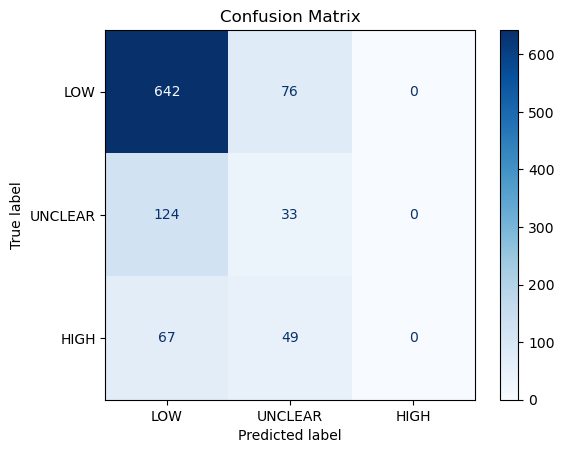

In [164]:
cm = confusion_matrix(df_eval['num_label'], df_eval['num_classification'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOW', 'UNCLEAR', 'HIGH'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues) # You can choose a different colormap
plt.title('Confusion Matrix')
plt.show()

Sample new 1000 with replacement. 

In [166]:
df_boot = df_eval.sample(n=1000, replace=True)
df_boot.head()

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,...,answers_start,question_y,context_y,classification,annotation,justification,baseline,num_label,num_classification,num_baseline
831,661811223c6e44b26b18ee64,CD012875,STD-Anderson_x002d_Berry-2017,Was the allocation sequence concealed until pa...,the study statistician generated a randomizati...,LOW,Allocation concealment (selection bias),QIT-02,PMC5634602.txt,51,...,605,Was the allocation sequence concealed until pa...,the study statistician generated a randomizati...,LOW,The study pharmacist randomized each infant.,This statement suggests that the allocation se...,LOW,0,0,0
863,661811223c6e44b26b190717,CD013017,STD-Kiely-2010,Was the outcome assessor blinded to the interv...,a computer generated randomization scheme cons...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC2988881.txt,86,...,440,Was the outcome assessor blinded to the interv...,a computer generated randomization scheme cons...,LOW,telephone interviewers and their supervisors w...,The annotation supports a LOW classification b...,LOW,0,0,0
711,661811223c6e44b26b18ec12,CD012110,STD-Demark_x002d_Wahnefried-2014a,Was the allocation sequence concealed until pa...,programmed actigraphs® were mailed to subjects...,LOW,Allocation concealment (selection bias),QIT-02,PMC4232005.txt,56,...,239,Was the allocation sequence concealed until pa...,programmed actigraphs® were mailed to subjects...,UNCLEAR,"Although it is not explicitly stated, the text...",The classification is UNCLEAR because the text...,LOW,0,1,0
238,661811223c6e44b26b18cba6,CD005330,STD-Johnston-2011,Was the allocation sequence random?,control group participants began treatment imm...,LOW,Random sequence generation (selection bias),QIT-01,PMC3223218.txt,119,...,639,Was the allocation sequence random?,control group participants began treatment imm...,LOW,the study states that the allocation sequence ...,The annotation supports the classification of ...,LOW,0,0,0
823,661811223c6e44b26b1905a5,CD012859,STD-Dabbous-1998,"Were the trial participants, staff, and study ...",the patients were then divided into two groups...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC3015295.txt,25,...,295,"Were the trial participants, staff, and study ...",the patients were then divided into two groups...,LOW,the staff caring for these patients were blind...,The annotation supports a LOW classification b...,LOW,0,0,0


In [167]:
df_eval.head()

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,...,answers_start,question_y,context_y,classification,annotation,justification,baseline,num_label,num_classification,num_baseline
0,6682e732cb7deacf322d4600,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,outcomes overall mean adherence was 61% ± 27%....,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,136,...,221,Incomplete outcome data addressed?,outcomes overall mean adherence was 61% ± 27%....,LOW,There were no differences between groups with ...,The annotation supports a LOW classification b...,LOW,2,0,0
1,661811223c6e44b26b18c628,CD000011,STD-Druss-2010,Was the allocation sequence random?,"(aday 1994; gelberg et al. 2000). thus, explor...",LOW,Random sequence generation (selection bias),QIT-01,PMC2856811.txt,104,...,299,Was the allocation sequence random?,"(aday 1994; gelberg et al. 2000). thus, explor...",LOW,The allocation sequence was determined by a co...,This indicates that the allocation sequence wa...,LOW,0,0,0
2,6682e732cb7deacf322d4608,CD000011,STD-Heisler-2010,Incomplete outcome data addressed?,all analyses were intention-to-treat. we also ...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC4117390.txt,101,...,268,Incomplete outcome data addressed?,all analyses were intention-to-treat. we also ...,LOW,We conducted alternative analyses adjusting fo...,This statement suggests that the researchers h...,LOW,0,0,0
3,6682ee67b5c1478c8cb3771c,CD000011,STD-Janson-2009,Free of selective reporting?,there were no significant differences between ...,HIGH,Selective reporting (reporting bias),QIT-05,PMC2729175.txt,80,...,338,Free of selective reporting?,there were no significant differences between ...,LOW,The authors stated that there were no signific...,This statement supports a LOW classification b...,LOW,2,0,0
4,661811223c6e44b26b18f2a0,CD000011,STD-Morgado-2011,Was the outcome assessor blinded to the interv...,although contamination was considered during t...,HIGH,Blinding of outcome assessment (detection bias),QIT-08,PMC3042105.txt,120,...,535,Was the outcome assessor blinded to the interv...,although contamination was considered during t...,UNCLEAR,Although contamination was considered during t...,The classification is UNCLEAR because the text...,LOW,2,1,0


In [168]:
for q in pd.unique(df_final['question']):
    print(q)

Incomplete outcome data addressed?
Was the allocation sequence random?
Free of selective reporting?
Was the allocation sequence concealed until participants were enrolled and assigned to interventions?
Was the outcome assessor blinded to the intervention?
Were the trial participants, staff, and study personnel blind to the intervention?


In [169]:
df_eval.shape

(991, 23)

Do bootstrapping x 1000. 

In [171]:
f1_micro_overall = []
f1_macro_overall = []
f1_weighted_overall = []
MAE_overall = []
MSE_overall = []
kappa_overall = []

f1_micro_baseline = []
f1_macro_baseline = []
f1_weighted_baseline = []
MAE_baseline = []
MSE_baseline = []
kappa_baseline = []

for i in range(1000):
    
    df_boot = df_eval.sample(n=991, replace=True)
    df_boot.head()
    
    f1_micro_overall.append(f1_score(df_boot['label'], df_boot['classification'], average='micro'))
    f1_macro_overall.append(f1_score(df_boot['label'], df_boot['classification'], average='macro'))
    f1_weighted_overall.append(f1_score(df_boot['label'], df_boot['classification'], average='weighted'))
    MAE_overall.append(mean_absolute_error(df_boot['num_label'], df_boot['num_classification']))
    MSE_overall.append(mean_squared_error(df_boot['num_label'], df_boot['num_classification']))
    kappa_overall.append(cohen_kappa_score(df_boot['num_label'], df_boot['num_classification'], weights='quadratic'))
    
    f1_micro_baseline.append(f1_score(df_boot['label'], df_boot['baseline'], average='micro'))
    f1_macro_baseline.append(f1_score(df_boot['label'], df_boot['baseline'], average='macro'))
    f1_weighted_baseline.append(f1_score(df_boot['label'], df_boot['baseline'], average='weighted'))
    MAE_baseline.append(mean_absolute_error(df_boot['num_label'], df_boot['num_baseline']))
    MSE_baseline.append(mean_squared_error(df_boot['num_label'], df_boot['num_baseline']))
    kappa_baseline.append(cohen_kappa_score(df_boot['num_label'], df_boot['num_baseline'], weights='quadratic'))
    
    # for q in pd.unique(df_final['question']):
    #     df_q = df_boot[df_boot['question_x'] ==  q]
    #     f1_score(df_q['label'],  df_q['classification'], average='micro')
    #     f1_score(df_q['label'],  df_q['classification'], average='macro')
    #     f1_score(df_q['label'],  df_q['classification'], average='weighted')
    #     mean_absolute_error(df_q['num_label'], df_q['num_classification'])
    #     mean_squared_error(df_q['num_label'], df_q['num_classification'])
    #     cohen_kappa_score(df_q['num_label'], df_q['num_classification'], weights='quadratic')

Create data frame

In [173]:
df_boots = pd.DataFrame({
    'f1_micro': f1_micro_overall
    , 'f1_macro': f1_macro_overall
    , 'f1_w': f1_weighted_overall
    , 'MAE': MAE_overall
    , 'MSE': MSE_overall
    , 'kappa': kappa_overall
    
    , 'b_f1_micro': f1_micro_baseline
    , 'b_f1_macro': f1_macro_baseline
    , 'b_f1_w': f1_weighted_baseline
    , 'b_MAE': MAE_baseline
    , 'b_MSE': MSE_baseline
    , 'b_kappa': kappa_baseline
})
df_boots.head()

,f1_micro,f1_macro,f1_w,MAE,MSE,kappa,b_f1_micro,b_f1_macro,b_f1_w,b_MAE,b_MSE,b_kappa
0,0.671039,0.322664,0.615022,0.396569,0.531786,0.195905,0.718466,0.278724,0.600761,0.398587,0.632694,0.0
1,0.697275,0.365390,0.649809,0.373360,0.514632,0.254168,0.727548,0.280763,0.612806,0.400605,0.656912,0.0
2,0.679112,0.323423,0.631665,0.387487,0.520686,0.184047,0.737639,0.283004,0.626265,0.375378,0.601413,0.0
3,0.693239,0.357498,0.655656,0.359233,0.464178,0.247853,0.739657,0.283449,0.628966,0.363269,0.569122,0.0
4,0.660949,0.317414,0.605757,0.410696,0.553986,0.179815,0.715439,0.278039,0.596760,0.405651,0.647830,0.0


Create new columns for differences.

In [175]:
df_boots['f1_micro_diff'] = df_boots['f1_micro'] - df_boots['b_f1_micro']
df_boots['f1_macro_diff'] = df_boots['f1_macro'] - df_boots['b_f1_macro']
df_boots['f1_w_diff'] = df_boots['f1_w'] - df_boots['b_f1_w']
df_boots['MAE_diff'] = df_boots['MAE'] - df_boots['b_MAE']
df_boots['MSE_diff'] = df_boots['MSE'] - df_boots['b_MSE']
df_boots['kappa_diff'] = df_boots['kappa'] - df_boots['b_kappa']
df_boots.head()

,f1_micro,f1_macro,f1_w,MAE,MSE,kappa,b_f1_micro,b_f1_macro,b_f1_w,b_MAE,b_MSE,b_kappa,f1_micro_diff,f1_macro_diff,f1_w_diff,MAE_diff,MSE_diff,kappa_diff
0,0.671039,0.322664,0.615022,0.396569,0.531786,0.195905,0.718466,0.278724,0.600761,0.398587,0.632694,0.0,-0.047427,0.043940,0.014261,-0.002018,-0.100908,0.195905
1,0.697275,0.365390,0.649809,0.373360,0.514632,0.254168,0.727548,0.280763,0.612806,0.400605,0.656912,0.0,-0.030272,0.084626,0.037003,-0.027245,-0.142281,0.254168
2,0.679112,0.323423,0.631665,0.387487,0.520686,0.184047,0.737639,0.283004,0.626265,0.375378,0.601413,0.0,-0.058527,0.040419,0.005401,0.012109,-0.080727,0.184047
3,0.693239,0.357498,0.655656,0.359233,0.464178,0.247853,0.739657,0.283449,0.628966,0.363269,0.569122,0.0,-0.046418,0.074048,0.026690,-0.004036,-0.104945,0.247853
4,0.660949,0.317414,0.605757,0.410696,0.553986,0.179815,0.715439,0.278039,0.596760,0.405651,0.647830,0.0,-0.054490,0.039375,0.008997,0.005045,-0.093845,0.179815


Get 95% confidence intervals. 

In [177]:
df_boots.quantile([0.025, 0.500, 0.975])

,f1_micro,f1_macro,f1_w,MAE,MSE,kappa,b_f1_micro,b_f1_macro,b_f1_w,b_MAE,b_MSE,b_kappa,f1_micro_diff,f1_macro_diff,f1_w_diff,MAE_diff,MSE_diff,kappa_diff
0.025,0.652876,0.323459,0.601805,0.350151,0.463143,0.156048,0.697275,0.273880,0.572910,0.353179,0.554970,0.0,-0.064581,0.043493,0.004805,-0.032316,-0.155399,0.156048
0.500,0.681130,0.345064,0.632937,0.386478,0.521191,0.211781,0.724521,0.280086,0.608784,0.393542,0.627649,0.0,-0.044400,0.064903,0.023460,-0.006054,-0.104945,0.211781
0.975,0.707366,0.370179,0.666210,0.422805,0.583274,0.271715,0.752775,0.286317,0.646598,0.434914,0.704364,0.0,-0.022200,0.090440,0.044876,0.019173,-0.059536,0.271715


# Qualitative analyses 

Get three random instances from each possible combination, including correct instances. 

**LOW**

In [181]:
df_00 = df_eval[(df_eval['classification'] == "LOW") & (df_eval['label'] == "LOW")]
df_00.shape

(642, 23)

The first one was bang on. It's unclear if the reasoning for the second one makes sense; it sounds plausible but the LLM may have focused on the wrong details. For the third one, it appears the LLM was right for the wrong reasons.

In [183]:
df_00s = df_00.sample(n=3, random_state=88)

for index, row in df_00s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Was the allocation sequence random?
at entry and at each study visit, study patients were instructed to perform 30 minutes of aerobic exercises 5 days a week and follow a healthy heart diet. the epa/dha supplementation included 2160 mg of epa and 1440 mg of dha in 2 divided doses and contained 72 calories. an identical placebo containing corn oil (72 calories) was administered in the same manner. patients were randomized by the sealed envelope technique using a random numbers table. the codes were broken only after primary analysis was completed. both formulations were yellow, oblong capsules without markings and with no discernible differences in odor or taste. the pufa formulation was a marine fish (anchovy and sardines) concentrate (0pti-epa™ ) and provided by douglas laboratories (pittsburg pa), which tested the quality and purity of the pufa.
---Llama---
LOW
patients were randomized by the sealed envelope technique using a random numbers table.
The use of a random number

In [184]:
df_01 = df_eval[(df_eval['classification'] == "LOW") & (df_eval['label'] == "UNCLEAR")]
df_01.shape

(124, 23)

For the first one, the LLM and humans agree on the annotation but disagree on the label; the LLM is arguably correct. Same assessment for the second one. Same assessment for the third one. 

In [186]:
df_01s = df_01.sample(n=3, random_state=88)

for index, row in df_01s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Were the trial participants, staff, and study personnel blind to the intervention?
all patients had albuterol provided for as-needed use. a triple-dummy study design was used to achieve study blinding, whereby patients were given three inhalers containing either an active drug or placebo. all patients and investigators were blinded to the assigned treatment during the study. however, exact physical placebo matches for the tio and ind capsules and for the ind blister packs were not available, although they were closely matched in color. as the study was of a parallel-group design, the capsule type was consistent for each patient for the duration of the study. both the tio and ind blister packages containing the capsules were covered with opaque over-labels. the handihaler® and breezhaler® devices were covered with labels to mask identifying markings.
---Llama---
LOW
all patients and investigators were blinded to the assigned treatment during the study.
The annotation supports 

In [187]:
df_02 = df_eval[(df_eval['classification'] == "LOW") & (df_eval['label'] == "HIGH")]
df_02.shape

(67, 23)

I might agree with the the LLM for the first one; I would have to review RoB tool. Similarly, I might agree with the LLM on the second one. I am not informed enough to comment on the third one. 

In [189]:
df_02s = df_02.sample(n=3, random_state=88)

for index, row in df_02s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Incomplete outcome data addressed?
intervention exposure students assigned to 101 viewed an average of 12/16 sections (76%; range 19–100%). nearly all students assigned to edu logged in (164/167, 98%), 157 (94%) took the final exam, and 153 (92%) achieved a passing score; 110 (66%) completed the final chapter. the bmis were implemented with fidelity; the interventionists covered an average of 91% of the 46 prescribed sections (range 74%–98%). attrition of the 677 participants who completed baseline, data were obtained from 96% at 1 month, 58% at 6 months, and 68% at 12 months; 78% completed at least two follow-ups. neither demographics nor intervention condition predicted attrition (ps &gt; 0.05). of the pre-sanction drinking variables, only higher peak bac predicted attrition (p &lt; 0.01). recidivism only 8% of the sample received one or more disciplinary contacts in the year after the original sanction.
---Llama---
LOW
Neither demographics nor intervention condition predic

**UNCLEAR**

In [191]:
df_10 = df_eval[(df_eval['classification'] == "UNCLEAR") & (df_eval['label'] == "LOW")]
df_10.shape

(76, 23)

For the first one, the annotation is appropriate but I am unsure about the LLM interpretation. For the second one, the LLM assessment seems reasonable but I agree with human that we can infer that outcome assessment was done independently. For the third one, the human answer does not match the label, whereas the LLM assessment seems reasonable.

In [193]:
df_10s = df_10.sample(n=3, random_state=88)

for index, row in df_10s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Was the allocation sequence random?
rhl is an annually updated electronic publication containing cochrane systematic reviews, commentaries and practical recommendations on how to implement evidence-based practices. we are conducting a trial to evaluate the improvement in obstetric practices using an active dissemination strategy to promote uptake of recommendations in the who reproductive health library (rhl). methods a cluster randomized trial to improve obstetric practices in 40 hospitals in mexico and thailand is conducted. the trial uses a stratified random allocation based on country, size and type of hospitals. the core intervention consists of three interactive workshops delivered over a period of six months. the main outcome measures are changes in clinical practices that are recommended in rhl measured approximately a year after the first workshop. results the design and implementation of a complex intervention using a cluster randomized trial design are presented.
-

In [194]:
df_11 = df_eval[(df_eval['classification'] == "UNCLEAR") & (df_eval['label'] == "UNCLEAR")]
df_11.shape

(33, 23)

First one: annotation and explanation consistent with human reviewers. Second one: annotation consistent with human reviewer. Third one: annotation consistent with human reviewers. 

In [196]:
df_11s = df_11.sample(n=3, random_state=88)

for index, row in df_11s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Were the trial participants, staff, and study personnel blind to the intervention?
group (b): treated with cc 100 mg for five days starting from cycle day five in addition to 10 mg isosorbid monoitrate (ismn) tablets (effox, minapharm, egypt under licence of shwarz pharma, germany) applied vaginally from day 2 to day 15 of the cycle. group (c): treated with cc 100 mg for five days starting from fifth day of cycle in addition to 20 mg ismn tablets applied vaginally from day 2 to day 15 of the cycle. randomization was done simply using sealed envelopes. the subject allocation was neither blinded to the patients nor to the physicians and investigators. cycle monitoring    vaginal ultrasonography   follicular growth in all patients was assessed using transvaginal ultrasound scans done every other day starting from cycle day 12 (mindray 6900 with frequency 7 mhz). presence of one or more follicle ≥18 mm that disappeared or changed in shape in subsequent scans was considered as an 

In [197]:
df_12 = df_eval[(df_eval['classification'] == "UNCLEAR") & (df_eval['label'] == "HIGH")]
df_12.shape

(49, 23)

First one: the annotation of the LLM is consistent with humans; it's justification seems reasonable. Second one: the identifies the right passage but failed to make the leap from data collector to outcome assessor; in its defence, however, it is not completely clear from limited context. Third one: LLM takes the question quite literally, looking for evidence of blinding across participants, staff, and personnel; anyway, its annotation is exact and justification is reasonable. 

In [199]:
df_12s = df_12.sample(n=3, random_state=88)

for index, row in df_12s.iterrows():
    print("QUESTION:", row['question_x'])
    print(row['context_x'])
    print("---Llama---")
    print(row["classification"])
    print(row["annotation"])
    print(row["justification"])
    print("---Answer---")
    print(row["label"])
    print(row["answers_text"])
    print("\n")

QUESTION: Were the trial participants, staff, and study personnel blind to the intervention?
they were also asked to stay comfortable in as calm and tranquil an environment as possible during the session. the eft treatment was provided by the first author, who was certified in eft. each 5-person group began by having the participants complete the pre-test sud, the stai-i, and the burnout scale via surveymonkey. eft was applied to each group of nurses in a single session of approximately 20 min. at the end of the session, participants again completed the post-test sud, the stai-i, and the burnout scale. implementation of eft  the 35 nurses in the eft group were divided into 7 subgroups of 5 participants each. after completing the descriptive characteristics form online, a time for the meeting was determined in collaboration with the participants in each subgroup.
---Llama---
UNCLEAR
the eft treatment was provided by the first author, who was certified in eft.
The annotation suggests tha

**HIGH**

There are no highs! 

In [202]:
sum(df_eval['classification'] == "HIGH")

0

In [203]:
df_20 = df_eval[(df_eval['classification'] == "HIGH") & (df_eval['label'] == "LOW")]
df_20.shape

(0, 23)

In [204]:
df_21 = df_eval[(df_eval['classification'] == "HIGH") & (df_eval['label'] == "UNCLEAR")]
df_21.shape

(0, 23)

In [205]:
df_22 = df_eval[(df_eval['classification'] == "HIGH") & (df_eval['label'] == "HIGH")]
df_22.shape

(0, 23)

# Binary task

In [207]:
bin_mapping = {"LOW": "LOW", "UNCLEAR": "UNCLEAR_HIGH", "HIGH": "UNCLEAR_HIGH"}

In [208]:
df_pulled = pd.read_csv(f"TEST_llama3.2:3b_0_1000_rand88.csv")
df_eval = pd.merge(df_final, df_pulled, on='id')
# df_eval['baseline'] = "LOW"

df_eval['bin_label'] = df_eval['label'].map(bin_mapping)
df_eval['bin_classification'] = df_eval['classification'].map(bin_mapping)
# df_eval['num_baseline'] = df_eval['baseline'].map(mapping)

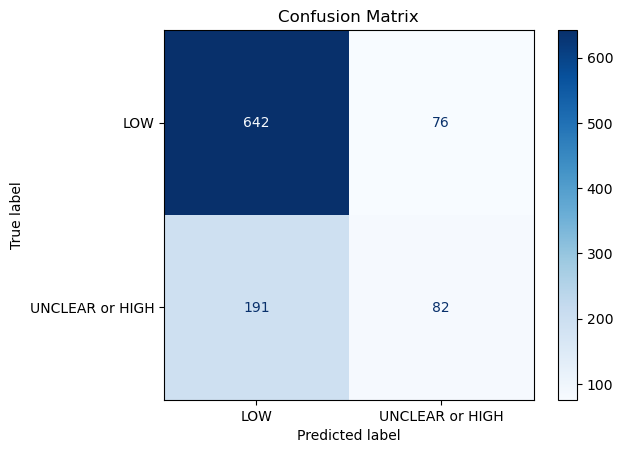

In [209]:
cm = confusion_matrix(df_eval['bin_label'], df_eval['bin_classification'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOW', 'UNCLEAR or HIGH'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues) # You can choose a different colormap
plt.title('Confusion Matrix')
plt.show()

In [210]:
f1_score(df_eval['bin_label'], df_eval['bin_classification'], average='macro')

0.6041817194505155

In [211]:
print(classification_report(df_eval['bin_label'], df_eval['bin_classification'], target_names = ["LOW", "UNCLEAR_HIGH"]))

              precision    recall  f1-score   support

         LOW       0.77      0.89      0.83       718
UNCLEAR_HIGH       0.52      0.30      0.38       273

    accuracy                           0.73       991
   macro avg       0.64      0.60      0.60       991
weighted avg       0.70      0.73      0.70       991

